In [1]:
import os
import pandas as pd
import re

def aggregate_pred_dataframe(files):
    dfs = [pd.read_csv(f) for f in files]
    final_df = dfs[0].rename(columns={'pred': 'pred_0'})
    for i in range(1, len(dfs)):
        final_df[f'pred_{i}'] = dfs[i]['pred']
    return final_df.reset_index()

def get_preds_with_prefix(prefix):
    csv_files = [file for file in os.listdir('preds') if file.endswith('.csv')]
    csv_files.sort()
    preds = []
    filtered = [file for file in csv_files if re.match(f'{prefix}_\d+_(test|valid)\.csv', file)]
    valid = [file for file in filtered if file.endswith('valid.csv')] # get valid file
    test = [file for file in filtered if file.endswith('test.csv')] # get test file
    for v, t in zip(valid, test):
        preds.append((v, t))
    print(preds)
    return preds

def aggregate_preds(preds):
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in preds])
    
    return df_valid, df_test

%matplotlib inline
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

def round_dict(d, n):
    return {k: round(v, n) if isinstance(v, float) else v
                for k, v in d.items()}
    

def compute_mcc_from_cm(tp, tn, fp, fn):
    # Calculate the denominator
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    
    # Check for zero denominator
    if denominator == 0:
        return 0  # or return float('nan')
    
    # Calculate MCC
    mcc = ((tp * tn) - (fp * fn)) / denominator
    return mcc

def generate_mean_ensemble_metrics(df, threshold=0):

    # Get the mean prediction
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].mean(axis=1)

    # Convert the mean predictions to binary based on the threshold
    final_prediction = (sum_preds > threshold).astype(int)

    # Compute the confusion matrix once
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    mcc = compute_mcc_from_cm(tp, tn, fp, fn)

    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }


def generate_hard_voting_ensemble_metrics(df, threshold=0):
    # Convert the float predictions to binary labels using the given threshold
    binary_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))] > threshold

    # Count the number of times a particular class (1 in this case) is predicted for each row
    vote_sum = binary_preds.sum(axis=1)
    
    # Decide the final prediction based on majority vote
    n_models = len(list(filter(lambda a: a.startswith('pred_'), df.columns.tolist())))
    final_prediction = (vote_sum > n_models / 2).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }
    
def draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-3, end=1, step=0.1,
                                      plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, step)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_mean_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }

def draw_hard_voting_threshold_chart(df_valid, df_test, start=-3, end=1, step=0.1,
                                      plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, step)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_hard_voting_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_hard_voting_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }


def random_small_ensembles(preds, n, trial, start=-3, end=1, step=0.1):
    from random import sample
    df = pd.DataFrame()
    for i in range(trial):
        sample_preds = sample(preds, n)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])


        new_row = [draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=False)]
        new_df = pd.DataFrame(new_row)
        df = pd.concat([df, new_df], ignore_index=True)

    return df

def apply_sig_df(df):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    # Apply the sigmoid function to all pred columns
    pred_columns = df.filter(like='pred_').columns
    df[pred_columns] = df[pred_columns].apply(sigmoid)
    return df

def summarize_prefix(prefix, plot=False, start=-3, end=1, step=0.1, apply_sig=False):
    preds = get_preds_with_prefix(prefix)
    df_valid, df_test = aggregate_preds(preds)
    print(f'Ensemble of all {len(preds)} models:')
    
    if apply_sig:
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        # Apply the sigmoid function to all pred columns
        pred_columns = df_valid.filter(like='pred_').columns
        df_valid[pred_columns] = df_valid[pred_columns].apply(sigmoid)
        df_test[pred_columns] = df_test[pred_columns].apply(sigmoid)
    print(round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=plot), 4))
    
    df = pd.DataFrame()
    for i in range(1, len(preds)+1):
        preds_first_i = preds[:i]
        df_valid, df_test = aggregate_preds(preds_first_i)
        if apply_sig:
            df_valid = apply_sig_df(df_valid)
            df_test = apply_sig_df(df_test)
        data = round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=False), 4)
        df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
    return df

import matplotlib.pyplot as plt

def summarize_prefix_wrap(prefix, apply_sig):
    if apply_sig:
        df = summarize_prefix(prefix, plot=True, start=0.1, end=0.7, step=0.01, apply_sig=True)
    else:
        df = summarize_prefix(prefix, plot=True, start=-3, end=1, step=0.1, apply_sig=apply_sig)
    
    # Plot the 'mcc' column with enhanced styling
    df.index += 1 
    ax = df.plot(y='mcc', figsize=(10, 6), color='blue', linestyle='-', marker='o', grid=True)
    
    mn = df['mcc'].min() // 0.01 / 100
    mx = df['mcc'].max() // 0.01 / 100
    ax.set_yticks(np.arange(mn, mx+0.01, 0.005))
    # Add title and labels
    ax.set_title("MCC vs. Ensemble Models", fontsize=18)
    ax.set_xlabel("Number of Models", fontsize=14)
    ax.set_ylabel("MCC", fontsize=14)
    
    # Style the gridlines and ticks
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add a legend
    ax.legend(["MCC"], fontsize=12, loc="upper left")
    
    # Finally, show the plot
    plt.tight_layout()
    plt.show()

    return df


[('ab_me_50_00_valid.csv', 'ab_me_50_00_test.csv'), ('ab_me_50_01_valid.csv', 'ab_me_50_01_test.csv'), ('ab_me_50_02_valid.csv', 'ab_me_50_02_test.csv'), ('ab_me_50_03_valid.csv', 'ab_me_50_03_test.csv'), ('ab_me_50_04_valid.csv', 'ab_me_50_04_test.csv'), ('ab_me_50_05_valid.csv', 'ab_me_50_05_test.csv'), ('ab_me_50_06_valid.csv', 'ab_me_50_06_test.csv'), ('ab_me_50_07_valid.csv', 'ab_me_50_07_test.csv'), ('ab_me_50_08_valid.csv', 'ab_me_50_08_test.csv'), ('ab_me_50_09_valid.csv', 'ab_me_50_09_test.csv'), ('ab_me_50_10_valid.csv', 'ab_me_50_10_test.csv'), ('ab_me_50_11_valid.csv', 'ab_me_50_11_test.csv'), ('ab_me_50_12_valid.csv', 'ab_me_50_12_test.csv'), ('ab_me_50_13_valid.csv', 'ab_me_50_13_test.csv'), ('ab_me_50_14_valid.csv', 'ab_me_50_14_test.csv'), ('ab_me_50_15_valid.csv', 'ab_me_50_15_test.csv'), ('ab_me_50_16_valid.csv', 'ab_me_50_16_test.csv'), ('ab_me_50_17_valid.csv', 'ab_me_50_17_test.csv'), ('ab_me_50_18_valid.csv', 'ab_me_50_18_test.csv'), ('ab_me_50_19_valid.csv', 'ab_

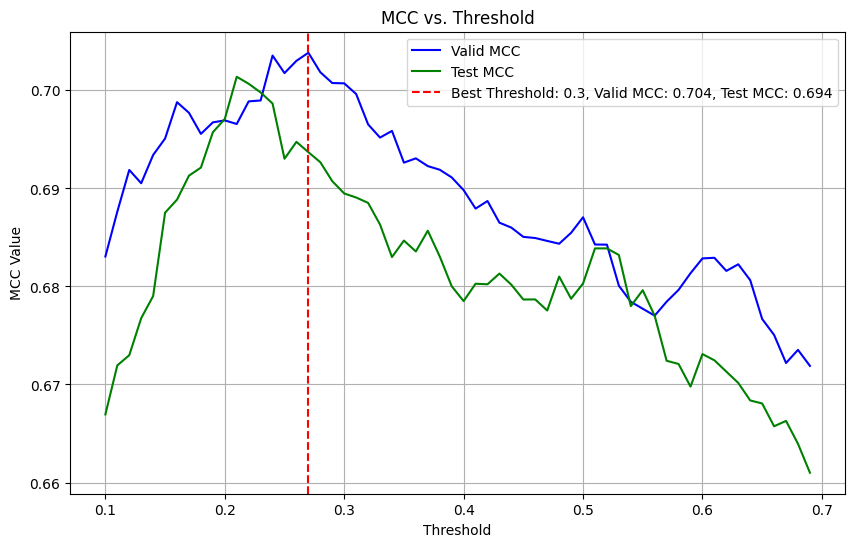

{'best_threshold': 0.27, 'valid_mcc': 0.7038, 'sensitivity': 0.6794, 'specificity': 0.9869, 'accuracy': 0.971, 'precision': 0.7396, 'mcc': 0.6937}


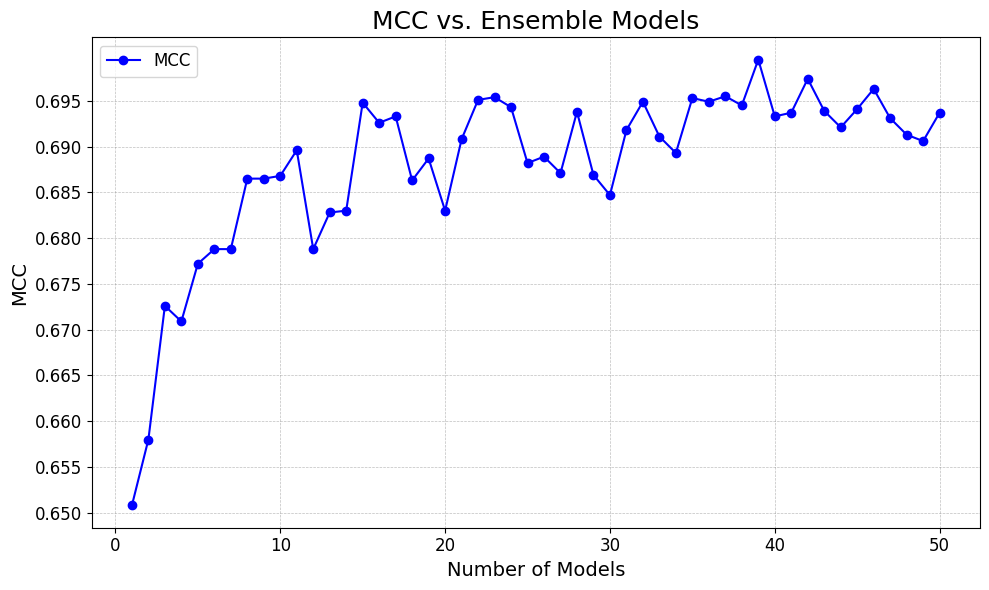

,best_threshold,valid_mcc,sensitivity,specificity,accuracy,precision,mcc
1,0.34,0.6767,0.6300,0.9858,0.9674,0.7079,0.6508
2,0.40,0.6808,0.6204,0.9876,0.9686,0.7326,0.6580
3,0.39,0.6971,0.6077,0.9905,0.9707,0.7776,0.6726
4,0.35,0.6959,0.6188,0.9894,0.9702,0.7608,0.6709
5,0.31,0.6938,0.6427,0.9881,0.9702,0.7463,0.6772
6,0.28,0.6979,0.6539,0.9873,0.9700,0.7374,0.6788
7,0.27,0.6954,0.6587,0.9868,0.9698,0.7323,0.6788
8,0.26,0.6964,0.6699,0.9868,0.9704,0.7356,0.6865
9,0.23,0.6954,0.6794,0.9860,0.9701,0.7257,0.6865
10,0.22,0.6972,0.6874,0.9853,0.9698,0.7183,0.6868


In [7]:
summarize_prefix_wrap('ab_me_50', apply_sig=True)

[('ab_me_70_00_valid.csv', 'ab_me_70_00_test.csv'), ('ab_me_70_01_valid.csv', 'ab_me_70_01_test.csv'), ('ab_me_70_02_valid.csv', 'ab_me_70_02_test.csv'), ('ab_me_70_03_valid.csv', 'ab_me_70_03_test.csv'), ('ab_me_70_04_valid.csv', 'ab_me_70_04_test.csv'), ('ab_me_70_05_valid.csv', 'ab_me_70_05_test.csv'), ('ab_me_70_06_valid.csv', 'ab_me_70_06_test.csv'), ('ab_me_70_07_valid.csv', 'ab_me_70_07_test.csv'), ('ab_me_70_08_valid.csv', 'ab_me_70_08_test.csv'), ('ab_me_70_09_valid.csv', 'ab_me_70_09_test.csv'), ('ab_me_70_10_valid.csv', 'ab_me_70_10_test.csv'), ('ab_me_70_11_valid.csv', 'ab_me_70_11_test.csv'), ('ab_me_70_12_valid.csv', 'ab_me_70_12_test.csv'), ('ab_me_70_13_valid.csv', 'ab_me_70_13_test.csv'), ('ab_me_70_14_valid.csv', 'ab_me_70_14_test.csv'), ('ab_me_70_15_valid.csv', 'ab_me_70_15_test.csv'), ('ab_me_70_16_valid.csv', 'ab_me_70_16_test.csv'), ('ab_me_70_17_valid.csv', 'ab_me_70_17_test.csv'), ('ab_me_70_18_valid.csv', 'ab_me_70_18_test.csv'), ('ab_me_70_19_valid.csv', 'ab_

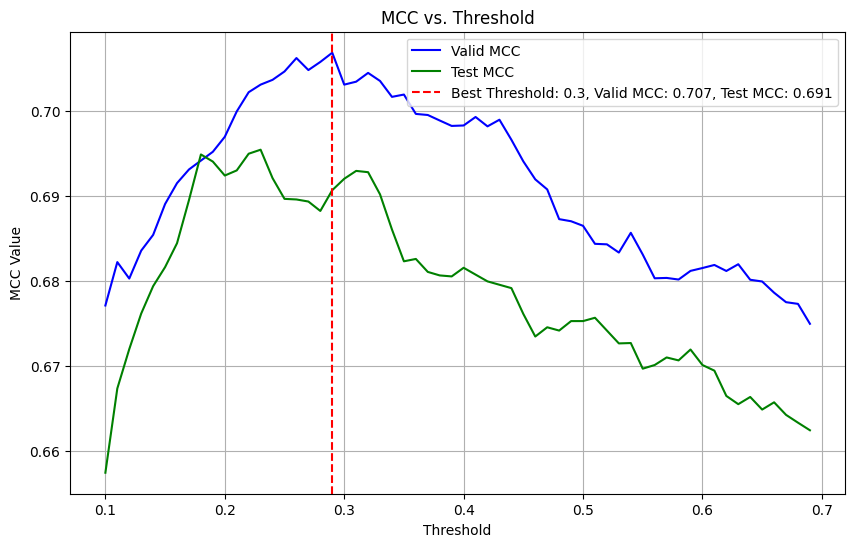

{'best_threshold': 0.29, 'valid_mcc': 0.7068, 'sensitivity': 0.673, 'specificity': 0.9871, 'accuracy': 0.9708, 'precision': 0.7404, 'mcc': 0.6907}


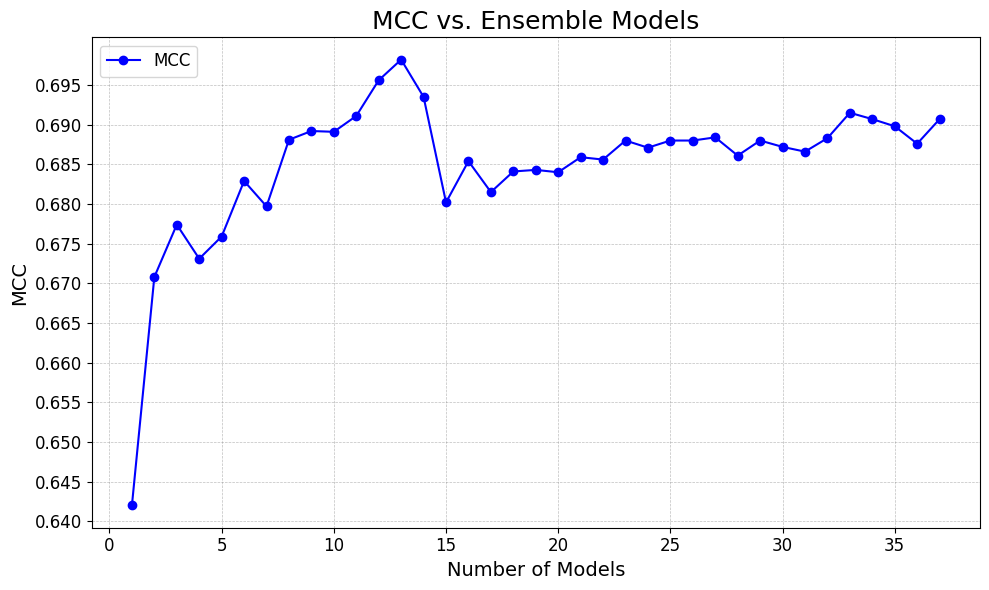

,best_threshold,valid_mcc,sensitivity,specificity,accuracy,precision,mcc
1,0.35,0.6694,0.6284,0.9848,0.9663,0.6924,0.6420
2,0.49,0.6771,0.6124,0.9899,0.9703,0.7680,0.6708
3,0.40,0.6907,0.6411,0.9882,0.9703,0.7486,0.6774
4,0.30,0.6891,0.6683,0.9852,0.9688,0.7114,0.6731
5,0.32,0.6932,0.6603,0.9863,0.9694,0.7250,0.6759
6,0.31,0.6937,0.6890,0.9846,0.9693,0.7094,0.6829
7,0.35,0.6953,0.6715,0.9858,0.9695,0.7209,0.6797
8,0.39,0.6980,0.6635,0.9876,0.9708,0.7455,0.6881
9,0.40,0.6963,0.6571,0.9883,0.9712,0.7546,0.6892
10,0.35,0.6972,0.6699,0.9872,0.9708,0.7407,0.6891


In [8]:
summarize_prefix_wrap('ab_me_70', apply_sig=True)

[('ab_me_90_00_valid.csv', 'ab_me_90_00_test.csv'), ('ab_me_90_01_valid.csv', 'ab_me_90_01_test.csv'), ('ab_me_90_02_valid.csv', 'ab_me_90_02_test.csv'), ('ab_me_90_03_valid.csv', 'ab_me_90_03_test.csv'), ('ab_me_90_04_valid.csv', 'ab_me_90_04_test.csv'), ('ab_me_90_05_valid.csv', 'ab_me_90_05_test.csv'), ('ab_me_90_06_valid.csv', 'ab_me_90_06_test.csv'), ('ab_me_90_07_valid.csv', 'ab_me_90_07_test.csv'), ('ab_me_90_08_valid.csv', 'ab_me_90_08_test.csv'), ('ab_me_90_09_valid.csv', 'ab_me_90_09_test.csv'), ('ab_me_90_10_valid.csv', 'ab_me_90_10_test.csv'), ('ab_me_90_11_valid.csv', 'ab_me_90_11_test.csv'), ('ab_me_90_12_valid.csv', 'ab_me_90_12_test.csv'), ('ab_me_90_13_valid.csv', 'ab_me_90_13_test.csv'), ('ab_me_90_14_valid.csv', 'ab_me_90_14_test.csv'), ('ab_me_90_15_valid.csv', 'ab_me_90_15_test.csv'), ('ab_me_90_16_valid.csv', 'ab_me_90_16_test.csv'), ('ab_me_90_17_valid.csv', 'ab_me_90_17_test.csv'), ('ab_me_90_18_valid.csv', 'ab_me_90_18_test.csv'), ('ab_me_90_19_valid.csv', 'ab_

/tmp/ipykernel_74561/2314791459.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[f'pred_{i}'] = dfs[i]['pred']
/tmp/ipykernel_74561/2314791459.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[f'pred_{i}'] = dfs[i]['pred']


Ensemble of all 100 models:


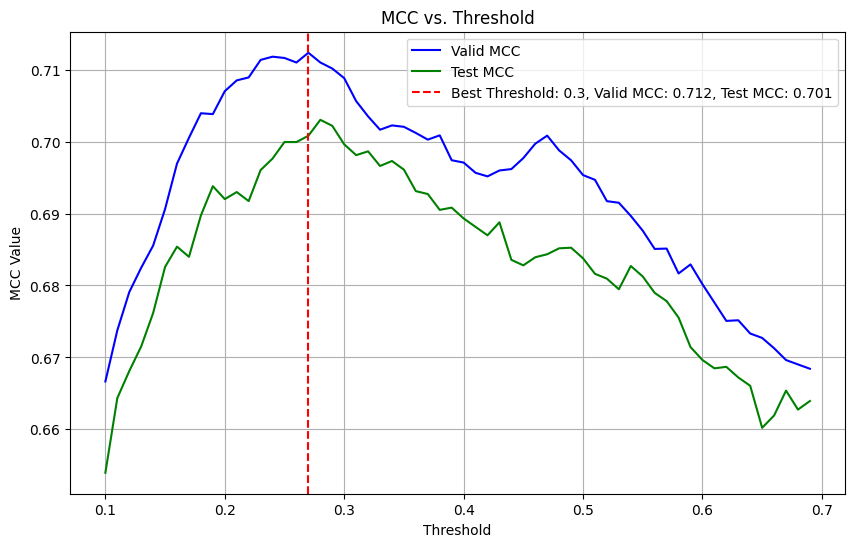

{'best_threshold': 0.27, 'valid_mcc': 0.7124, 'sensitivity': 0.6938, 'specificity': 0.9866, 'accuracy': 0.9714, 'precision': 0.7385, 'mcc': 0.7008}


/tmp/ipykernel_74561/2314791459.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[f'pred_{i}'] = dfs[i]['pred']
/tmp/ipykernel_74561/2314791459.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[f'pred_{i}'] = dfs[i]['pred']


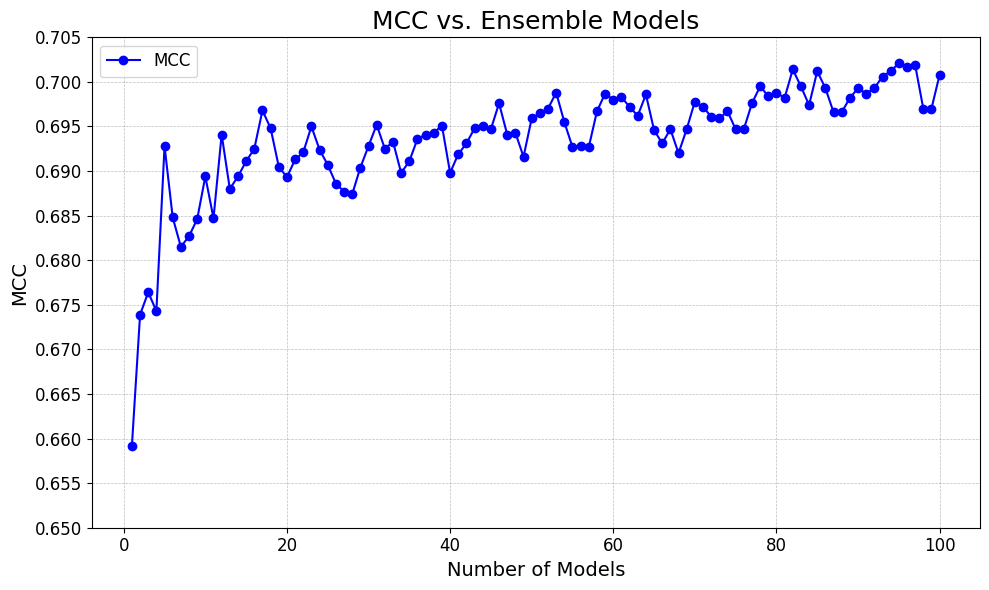

,best_threshold,valid_mcc,sensitivity,specificity,accuracy,precision,mcc
1,0.18,0.6799,0.6491,0.9851,0.9677,0.7042,0.6592
2,0.48,0.6853,0.6220,0.9895,0.9704,0.7632,0.6739
3,0.37,0.6799,0.6475,0.9875,0.9699,0.7395,0.6764
4,0.40,0.6854,0.6523,0.9868,0.9695,0.7304,0.6743
5,0.47,0.6922,0.6364,0.9905,0.9722,0.7854,0.6928
...,...,...,...,...,...,...,...
96,0.26,0.7121,0.6970,0.9864,0.9714,0.7369,0.7017
97,0.28,0.7122,0.6906,0.9870,0.9717,0.7440,0.7019
98,0.24,0.7125,0.7033,0.9852,0.9706,0.7218,0.6970
99,0.24,0.7118,0.7033,0.9852,0.9706,0.7218,0.6970


In [2]:

summarize_prefix_wrap('ab_me_90', apply_sig=True)

[('ab_me_95_00_valid.csv', 'ab_me_95_00_test.csv'), ('ab_me_95_01_valid.csv', 'ab_me_95_01_test.csv'), ('ab_me_95_02_valid.csv', 'ab_me_95_02_test.csv'), ('ab_me_95_03_valid.csv', 'ab_me_95_03_test.csv'), ('ab_me_95_04_valid.csv', 'ab_me_95_04_test.csv'), ('ab_me_95_05_valid.csv', 'ab_me_95_05_test.csv'), ('ab_me_95_06_valid.csv', 'ab_me_95_06_test.csv'), ('ab_me_95_07_valid.csv', 'ab_me_95_07_test.csv'), ('ab_me_95_08_valid.csv', 'ab_me_95_08_test.csv'), ('ab_me_95_09_valid.csv', 'ab_me_95_09_test.csv'), ('ab_me_95_10_valid.csv', 'ab_me_95_10_test.csv'), ('ab_me_95_11_valid.csv', 'ab_me_95_11_test.csv'), ('ab_me_95_12_valid.csv', 'ab_me_95_12_test.csv'), ('ab_me_95_13_valid.csv', 'ab_me_95_13_test.csv'), ('ab_me_95_14_valid.csv', 'ab_me_95_14_test.csv'), ('ab_me_95_15_valid.csv', 'ab_me_95_15_test.csv'), ('ab_me_95_16_valid.csv', 'ab_me_95_16_test.csv'), ('ab_me_95_17_valid.csv', 'ab_me_95_17_test.csv'), ('ab_me_95_18_valid.csv', 'ab_me_95_18_test.csv'), ('ab_me_95_19_valid.csv', 'ab_

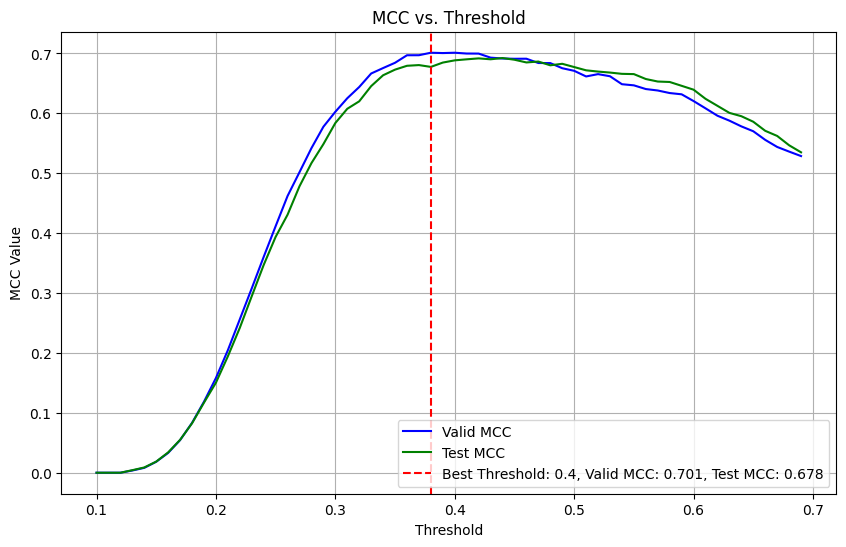

{'best_threshold': 0.38, 'valid_mcc': 0.7012, 'sensitivity': 0.6874, 'specificity': 0.984, 'accuracy': 0.9686, 'precision': 0.7008, 'mcc': 0.6775}


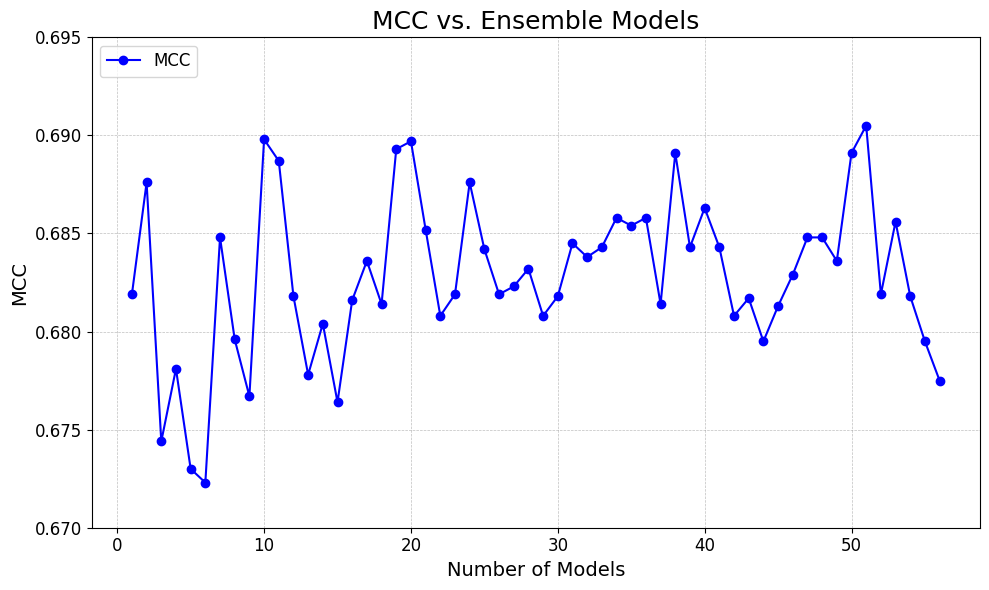

,best_threshold,valid_mcc,sensitivity,specificity,accuracy,precision,mcc
1,0.19,0.6798,0.6475,0.9882,0.9706,0.7505,0.6819
2,0.51,0.6780,0.6300,0.9904,0.9717,0.7822,0.6876
3,0.57,0.6936,0.6348,0.9884,0.9701,0.7495,0.6744
4,0.57,0.6967,0.6587,0.9868,0.9698,0.7310,0.6781
5,0.66,0.6873,0.6029,0.9909,0.9708,0.7842,0.6730
6,0.54,0.6899,0.6842,0.9835,0.9680,0.6942,0.6723
7,0.56,0.6911,0.6635,0.9872,0.9704,0.7389,0.6848
8,0.54,0.6906,0.6730,0.9856,0.9694,0.7189,0.6796
9,0.50,0.6941,0.6762,0.9849,0.9689,0.7102,0.6767
10,0.51,0.6977,0.6699,0.9873,0.9708,0.7420,0.6898


In [5]:

summarize_prefix_wrap('ab_me_95', apply_sig=True)